# Max-Cut on Dirac
#### Device: Dirac-1

## Introduction

The Maximum Cut (max-cut) problem is a well known NP-hard problem in combinatorial optimization used in quantum computing demonstrations due to its efficient, natural formulation as a QUBO or Ising Hamiltonian. The goal of the problem is to separate the nodes of a graph into two subsets, where the number of edges between the two sets is maximal. This is a maximum cut. Unlike [graph partitioning](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/graph-partitioning-on-dirac), which has a more conceptually defined goal, finding a max-cut has a clear mathematical definition. In some ways, max-cut can be thought of as the opposite problem to graph partitioning. Instead of separating groups of nodes that are highly connected among themselves and less connected with others, the goal is to divide the graph in such a way that the number of edges crossing between the groups is as large as possible.

## Importance

Graphs, which formally consist of nodes connected by edges, arise in a wide variety of settings. A fundamental reason for the importance of graphs is the significance of pairwise relationships between different entities. For example, in social contexts, whether a pair of people get along is fundamental to group cohesion. Communication also tends to be pairwise. For example, whether devices can directly communicate is usually naturally represented as a graph. Pairwise correlations tend to be very important in statistical analysis. For this reason, graph problems like max-cut and graph partitioning have a number of real-world applications. Max-cut is particularly simple to implement in the [Ising formalism](https://quantumcomputinginc.com/learn/lessons/ising-models), since positive ([anti-ferromagnetic](https://hal.science/hal-02888376/document)) couplers correspond to edges that reduce the objective function value when cut. Since Ising models frequently arise in the context of quantum computing, max-cut is often [used as a benchmark](https://arxiv.org/pdf/2302.02278). In fact, the demonstration used in this tutorial uses an instance that has been [made publicly available for such benchmarks](https://github.com/SRI-International/QC-App-Oriented-Benchmarks/blob/8a1f2a4712dca6d1d4429e19a3cb6156673ac841/maxcut/README.md). However, max-cut is not exclusively a benchmarking problem. It also has important real-world applications.

## Applications

Although it may at first seem counterintuitive, max-cut can be used to cluster related data points together. if higher weights on the edges indicate stronger differences, then the maximum cut of these edges will be meaningful. A maximum cut will divide the graph into sets of nodes that are maximally different from each other. A specific application that only involves weights of $\pm 1$ is to have each edge represent information that two nodes should be on opposite sides of the cut ($+1$) or the same side ($-1$) [effectively providing a "clustering" method](http://proceedings.mlr.press/v130/chatziafratis21a/chatziafratis21a.pdf). Another commonly mentioned application is integrated circuit design, specifically very large scale integrated (VSLI) circuits. This application is commonly formulated as a situation where the binary variables determine which [side of two-sided chip components](https://www.researchgate.net/publication/262162554_An_Application_of_Combinatorial_Optimization_to_Statistical_Physics_and_Circuit_Layout_Design) are placed to minimize the number of holes drilled through the chip. Here, both positive and negative weighted edges corresponding to preferences of the same or opposite sides for components. A more esoteric application is to statistical physics. Given the close connection with the Ising model, max-cut problems can be thought of as finding the lowest energy states, known as ground states of [certain magnetic systems](http://eprints.lse.ac.uk/113471/1/Ising_antiferromagnet_revised_clean.pdf).

## Objective
The demo uses the 320 node instance from [QED-C QC-App-Oriented-Benchmarks Max Cut](https://github.com/SRI-International/QC-App-Oriented-Benchmarks/blob/8a1f2a4712dca6d1d4429e19a3cb6156673ac841/maxcut/README.md). The instance is loaded from its text format, which is specified as a node-node pair per line. An undirected, unweighted NetworkX graph is created from the edge descriptions. The solution to the problem instance is specified in the `sol` file with the objective value in the first line. This value will be compared to the result at the completion of the QC sampling. 

A figure is drawn on the graph with a circular layout. This layout choice gives a good visual representation of the edges before and after the cuts are applied. In the figure that follows the determination of a solution, the nodes are colored green or red, depending on which set they are in. Each edge will have the same color node at either end, indicating that the edge does not connect the sets.

To solve the max-cut problem, an Ising Hamiltonian representation of the graph is used. Each dimension of the Hamiltonian represents the choice of a certain node being in one subset or the other. This is where the efficiency is visible because the edges are represented by nonzero values in the quadratic coefficients. Dirac-1 requires that the quadratic portion of the Hamiltonian is symmetric, so 0.5 is added to both coefficients for each `(i, j)` pair. The linear portion of the Hamiltonian is all zero. The coefficients of the Hamiltonian are uploaded to Qatalyst as a single two-dimensional array. The first column contains the linear coefficients, and the additional `N` columns are the quadratic coefficients. The file ID is saved, and then specified in the job request of type `sample-hamiltonian`.

In the job response, the `results` object has an array named `samples`. The array has values either -1 or 1, for the Ising Hamiltonian formulation. Meaning can be assigned to the sets after the solution is obtained, but there is no meaning to be derived from the set assignment outside of the members of the sets themselves. This is true because we know that the negative of the solution array gives the same value for the Hamiltonian as the solution provided.

## Running this Notebook

In order to run this notebook, clone [the qatalyst-examples repository from GitHub](https://github.com/qci-github/qatalyst-examples) and either run the `max-cut-demo.ipynb` notebook there or copy the `data` folder to where you have this notebook saved. Install the required Python packages by executing 
```
$ pip install -r requirements.txt
```


In [1]:
import os.path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import qci_client as qc
mc_instance_file = "mc_320_003_000.txt"
mc_solution_file = "mc_320_003_000.sol"

In [2]:
def get_results(response):
    if "results" in response and response["results"] is not None:
        results = response["results"]
    else:
        if "job_info" in response and "job_result" in response["job_info"]:
            details = response["job_info"]["job_result"]
        else:
            details = None
        raise RuntimeError(f"Execution failed. See details: {details}")
    return results

In [3]:
G = nx.Graph()
with open(mc_instance_file) as mc_file:
    N = int(mc_file.readline().strip())
    loading = True
    while loading:
        line = mc_file.readline()
        if line:
            u, v = line.split(" ")
            u = int(u)
            v = int(v)
            G.add_edge(u, v)
        else:
            loading = False

In [4]:
max_cuts = int(open(mc_solution_file).readline().strip())
print(f"Known optimal solution has {max_cuts} cuts")

Known optimal solution has 441 cuts


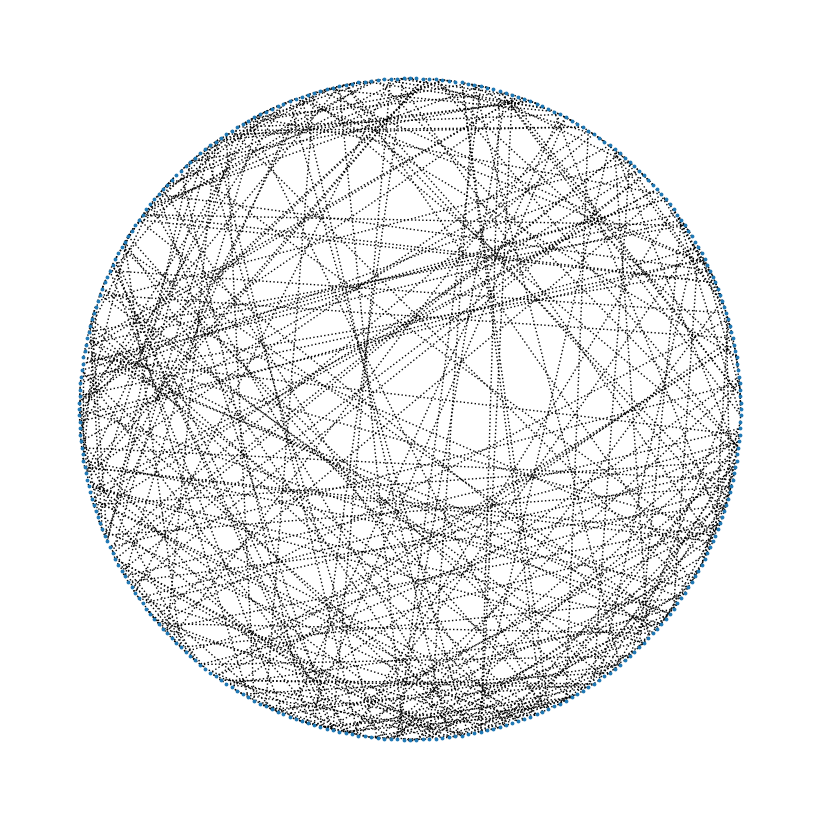

In [5]:
fig = plt.figure(figsize=(8, 8))
nx.draw_circular(G, node_size=3, width=1, style=":")

## Max-Cut Qubo Formulation 
Let $x_i\in\left\{0,1\right\}$ indicate node $i$ is in partition 1 ($x_i=0$) or partition 2 ($x_i=1$). Then 
$$
x_i+x_j-2x_ix_j
$$
will equal 1 if either $x_i$ or $x_j$ exclusively equal 1, but 0 if the are the same. Iterating over all edges in the graph, we set the coefficients to the negative of these values in order to maximize the objective.

In [6]:
# Create a Hamiltonian Operator
n = len(G.nodes)
Q = np.zeros((n, n))
for u, v in G.edges:
    Q[u, v] += 1
    Q[v, u] += 1
    Q[u, u] -= 1
    Q[v, v] -= 1

In [7]:
token = "your_token"
api_url = "https://api.qci-prod.com"
client = qc.QciClient(api_token=token, url=api_url)

In [8]:
file_def = {"file_name": "max-cut-mc320-003", "file_config": {"qubo": {"data": Q}}}
file_id = client.upload_file(file=file_def)["file_id"]

In [9]:
job_body = client.build_job_body(job_type="sample-qubo", qubo_file_id=file_id,
                                 job_params={"device_type": "dirac-1", "num_samples": 15})
job_response = client.process_job(job_body=job_body)

2024-05-08 15:47:37 - Dirac allocation balance = 0 s (unmetered)
2024-05-08 15:47:38 - Job submitted: job_id='663c010ad448b017e54f94cb'
2024-05-08 15:47:38 - QUEUED
2024-05-08 15:47:40 - RUNNING
2024-05-08 15:52:32 - COMPLETED
2024-05-08 15:52:34 - Dirac allocation balance = 0 s (unmetered)


A new graph is constructed from the nodes of the original graph, then edges added only if the solution provided has the nodes in the same sets. When the nodes are in different sets, the edge is cut, increasing the cut size by 1

In [10]:
cut_size = 0
Gprime = nx.Graph()
Gprime.add_nodes_from(G.nodes)
results = get_results(job_response)
sample = results["solutions"][0]
for u, v in G.edges:
    if sample[u] != sample[v]:
        cut_size += 1
    else:
        Gprime.add_edge(u, v)
print("Cut", cut_size, "out of", max_cuts, "which is {:.1%} off of optimal".format((max_cuts-cut_size) / max_cuts))

Cut 430 out of 441 which is 2.5% off of optimal


This is the figure described earlier, with all edges between a pair of nodes in the same set.

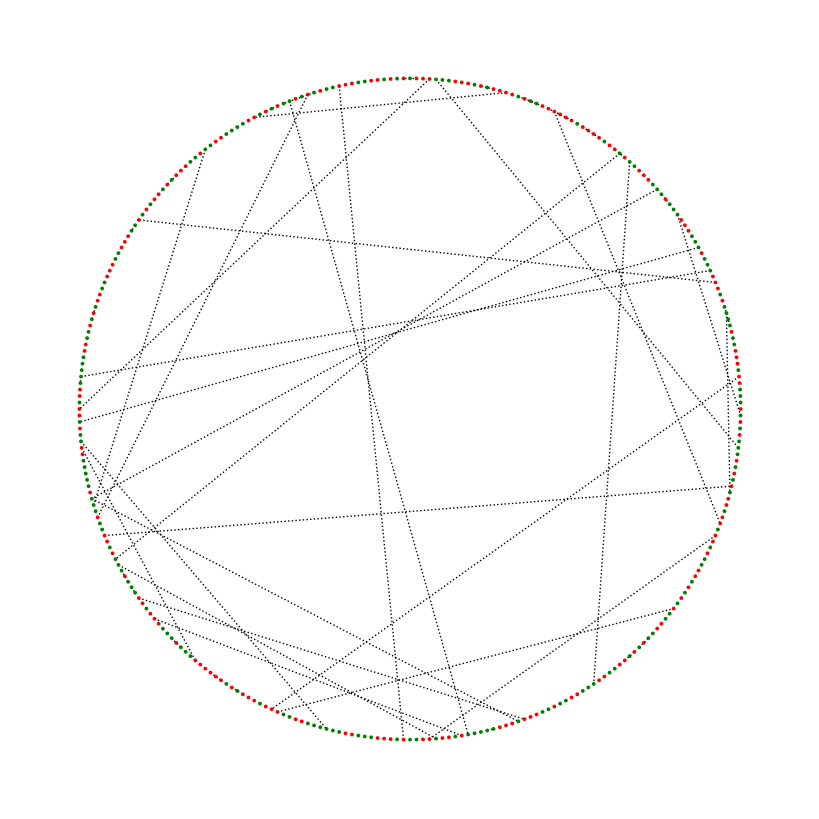

In [11]:
binary_sample = [int((sample[u] + 1) / 2) for u in G.nodes]
color_choices = ["red", "green"]
node_colors = [color_choices[u] for u in binary_sample]
fig = plt.figure(figsize=(8, 8))
nx.draw_circular(Gprime, node_color=node_colors, node_size=3, width=1, style=":")

## Conclusion

In this tutorial we have shown how to solve max-cut problems on Dirac. Specifically, we have taken a problem from a well known quantum benchmarking repository as an example. If any of the discussed applications of max-cut are of interest, it may be worth seeing our tutorial on the related (but less well-defined) problem of [graph partitioning](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/graph-partitioning-on-dirac). The max-cut problem is an example of a quadratic unconstrained binary optimization problem, and more examples of such problems are linked in [here](https://quantumcomputinginc.com/learn/module/understanding-qubos). On the other hand, consider our module on [quadratic linearly constrained binary optimization](https://quantumcomputinginc.com/learn/module/understanding-qlcbos), as many important real-world problems include constraints. Of course, another option is to start using our device to solve some of your own optimization problems.